# Imports

In [48]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

# Getting Data

## Dataset and Training Parameters

In [2]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCH = 20
GLOBAL_CLIPNORM = 10.0

## Dataset Preparation

In [17]:
class_ids = ["Waldo", "NotWaldo"]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../raw_data/data/label_new/images"
path_annot = "../raw_data/data/label_new/annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [18]:
# xml_files

**Next is parsing the XML annotation files to store the labels and bounding box annotations needed for training.**

In [19]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/47 [00:00<?, ?it/s]

In [20]:
bbox = tf.ragged.constant(bbox, dtype=tf.float32)
classes = tf.ragged.constant(classes, dtype=tf.float32)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [21]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

NotImplementedError: in user code:

    File "/tmp/ipykernel_37919/42308185.py", line 11, in load_dataset  *
        image = load_image(image_path)
    File "/tmp/ipykernel_37919/42308185.py", line 4, in load_image  *
        print(plt.imshow(image))
    File "/home/victor/.pyenv/versions/3.10.6/envs/wheres-waldo/lib/python3.10/site-packages/matplotlib/pyplot.py", line 3358, in imshow  **
        __ret = gca().imshow(
    File "/home/victor/.pyenv/versions/3.10.6/envs/wheres-waldo/lib/python3.10/site-packages/matplotlib/__init__.py", line 1465, in inner
        return func(ax, *map(sanitize_sequence, args), **kwargs)
    File "/home/victor/.pyenv/versions/3.10.6/envs/wheres-waldo/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 5759, in imshow
        im.set_data(X)
    File "/home/victor/.pyenv/versions/3.10.6/envs/wheres-waldo/lib/python3.10/site-packages/matplotlib/image.py", line 723, in set_data
        self._A = self._normalize_image_array(A)
    File "/home/victor/.pyenv/versions/3.10.6/envs/wheres-waldo/lib/python3.10/site-packages/matplotlib/image.py", line 686, in _normalize_image_array
        A = cbook.safe_masked_invalid(A, copy=True)
    File "/home/victor/.pyenv/versions/3.10.6/envs/wheres-waldo/lib/python3.10/site-packages/matplotlib/cbook.py", line 733, in safe_masked_invalid
        x = np.array(x, subok=True, copy=copy)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (DecodeJpeg:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


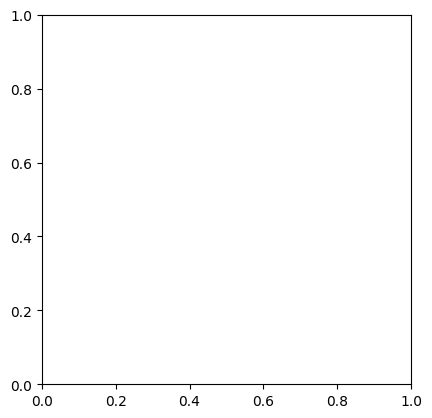

In [50]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    print(plt.imshow(image))
    return image



def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = keras.Sequential(
    layers=[
    keras_cv.layers.RandomFlip(mode="horizontal_and_vertical", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.8, 1.25),
            bounding_box_format="xyxy",
        ),
        keras_cv.layers.RandomRotation(factor=0.15, bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.8, 1.25),
            bounding_box_format="xyxy",
        ),
        keras_cv.layers.RandomHue((0.5, 0.5), [0, 255]),
        keras_cv.layers.RandomContrast([0, 255], (0.5, 0.5)),
        keras_cv.layers.RandomSaturation((0.5, 0.5)),
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=False)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
for i in train_ds.take():
    print(i['images'])

tf.Tensor(
[[[[ 66.9622     73.13997    65.48184  ]
   [ 64.57207    68.967224   64.28074  ]
   [ 73.36973    75.95098    74.598    ]
   ...
   [ 99.66225    77.55086   101.997536 ]
   [139.57272   114.867874  142.97876  ]
   [167.90073   141.86703   173.07935  ]]

  [[ 73.443085   78.431244   72.94165  ]
   [ 65.03114    69.37727    65.81984  ]
   [ 73.37584    75.16422    75.348625 ]
   ...
   [109.86663    92.595856  108.569824 ]
   [147.31075   126.201035  147.44455  ]
   [170.46642   146.63235   172.65393  ]]

  [[ 74.36912    78.97174    74.314255 ]
   [ 67.46427    71.310974   69.00991  ]
   [ 65.95088    68.073      68.75964  ]
   ...
   [123.85879   111.820816  120.619865 ]
   [154.6654    138.53415   153.10127  ]
   [175.43521   155.47624   176.2354   ]]

  ...

  [[ 74.64905    80.91008    66.55092  ]
   [ 54.75492    61.000572   51.43968  ]
   [ 63.3151     69.63391    63.20454  ]
   ...
   [ 54.87085    70.867905   67.26671  ]
   [ 87.30153   103.80675    99.38222  ]
   [1

2024-03-07 11:59:15.213866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(20)))
    # inputs = inputs.take(1)
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

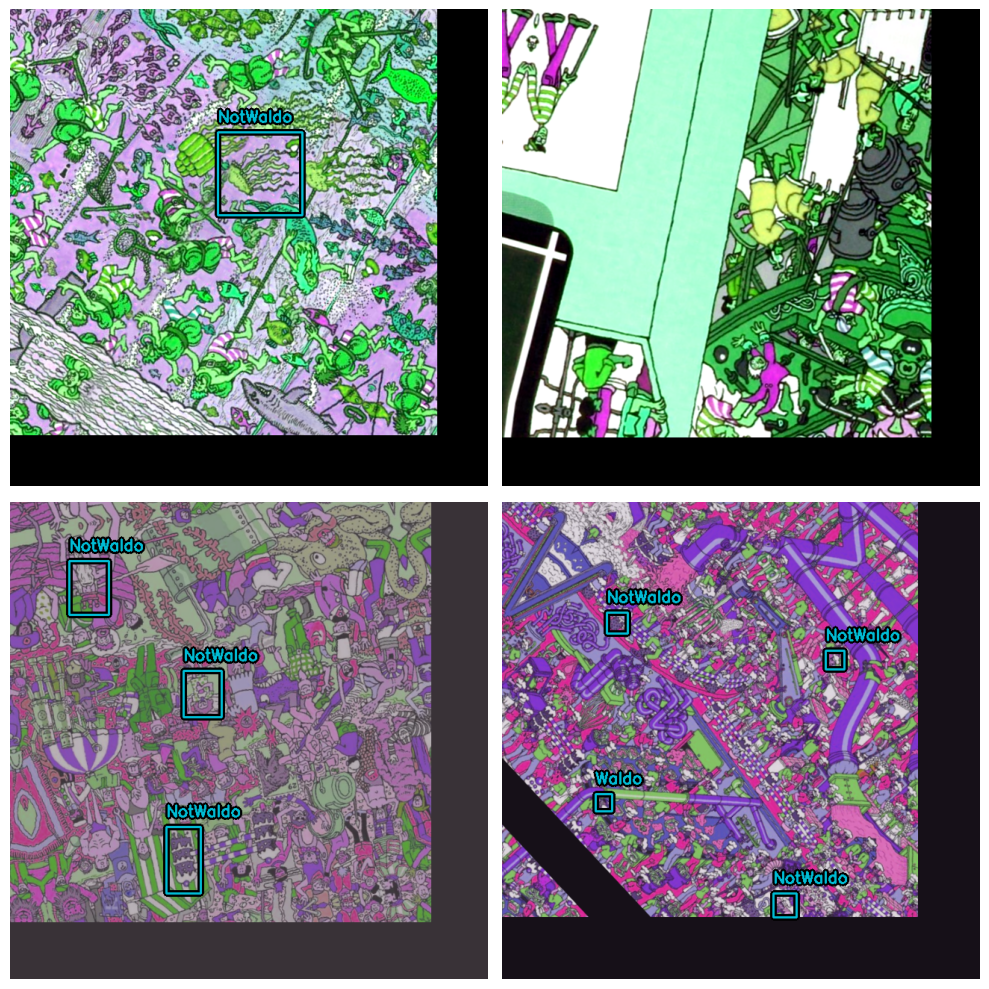

In [47]:
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)


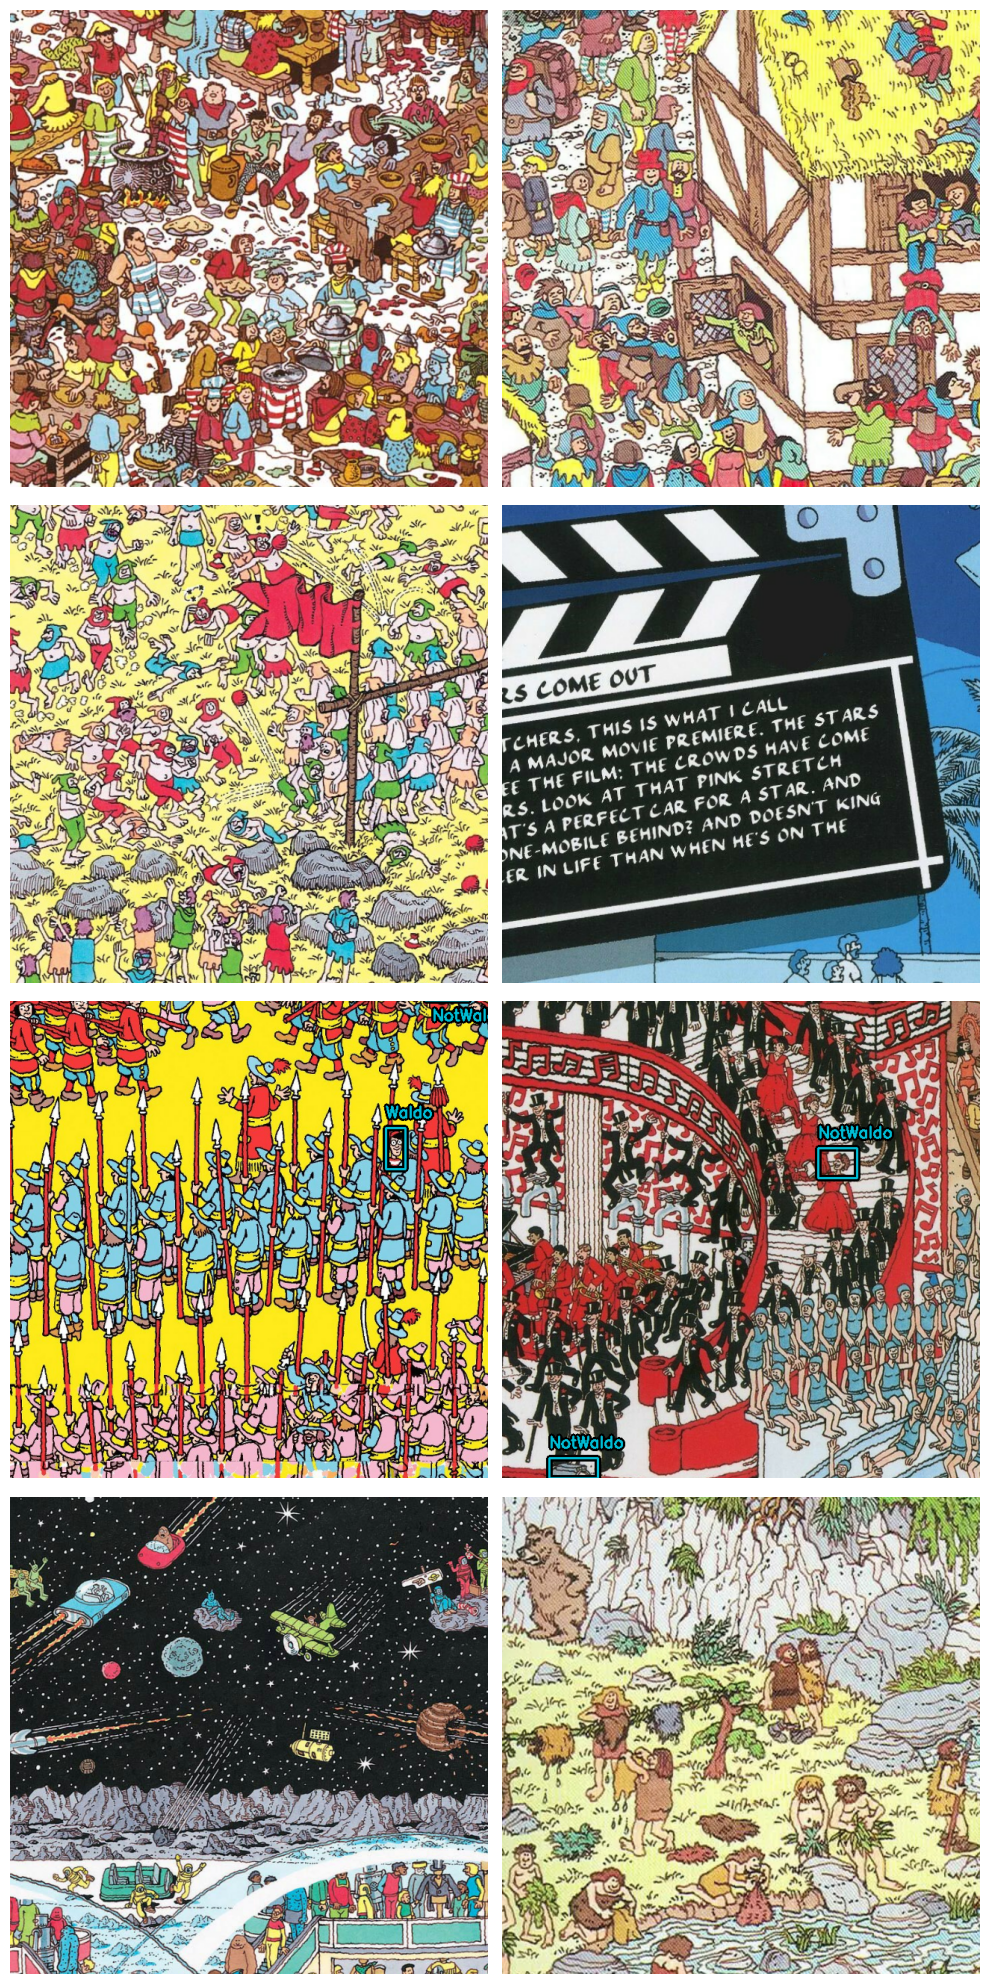

In [32]:
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=4, cols=2
)

In [27]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [132]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

yolo.count_params()

41051523

In [133]:
for layer in yolo.layers:
  if isinstance(layer, tf.keras.layers.Conv2D):
    layer.trainable = False
  else:
    layer.trainable = True

In [134]:
# yolo.summary()

In [135]:
def focal_loss(y_true, y_pred):
  gamma = 2.0
  alpha = 0.25

  pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
  loss = -alpha * (1.0 - pt)**gamma * tf.math.log(tf.clip_by_value(pt, 1e-15, 1.0 - 1e-15))

  return loss

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss=focal_loss, box_loss="ciou"
)

In [136]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path + '.keras')  # Save the model when mAP improves

        return logs

In [137]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [138]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=75,
    restore_best_weights=True,
    monitor='val_loss',
    mode='max'
)

callbacks=[
    EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),
    tensorboard_callback,
    early_stopping
]

In [ ]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=callbacks
)

Epoch 1/20
2/4 [==============>...............] - ETA: 2:53 - loss: 5.7353 - box_loss: 5.7086 - class_loss: 0.0268

In [ ]:
history.history

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    for i in range(10):
        images, y_true = next(iter(dataset.take(i+1)))
        y_pred = model.predict(images)
        y_pred = bounding_box.to_ragged(y_pred)
        visualization.plot_bounding_box_gallery(
            images,
            value_range=(0, 255),
            bounding_box_format=bounding_box_format,
            # y_true=y_true,
            y_pred=y_pred,
            scale=4,
            rows=2,
            cols=2,
            show=True,
            font_scale=0.7,
            class_mapping=class_mapping,
        )
visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")